In [1]:
import json
import os
import sys

sys.path.append('/home/luis/CGE/luxgiant-dstream/luxgiant_dstream')
#sys.path.append('/mnt/0A2AAC152AABFBB7/CGE/luxgiant-dstream')

from luxgiant_dstream.prep_ds import PrepDS
from luxgiant_dstream.gwas_fixed import GWASfixed
from luxgiant_dstream.gwas_random import GWASrandom

In [2]:
#params = json.load(open("/mnt/0A2AAC152AABFBB7/data/LuxGiantimputed/configFiles/parameters.JSON"))
#paths = json.load(open("/mnt/0A2AAC152AABFBB7/data/LuxGiantimputed/configFiles/paths_home_local.JSON"))

params = json.load(open("/home/luis/data/LuxGiantimputed/configFiles/parameters.JSON"))
paths = json.load(open("/home/luis/data/LuxGiantimputed/configFiles/paths_local.JSON"))

In [3]:
gwas_f = GWASfixed(
    input_path = paths['input_directory'],
    input_name = paths['input_prefix'],
    output_path= paths['output_directory'],
    output_name= paths['output_prefix'],
    dependables= paths['dependables_directory'],
    config_dict= params,
    preps_path = os.path.join(paths['output_directory'], 'preparatory'),
)
gwas_f.compare_gwas_fixed_file_name = 'european_cohort_nallsEtAl2019_excluding23andMe_allVariants.hg38.tsv'
gwas_f.compare_gwas_fixed_highlights= 'highlighted_european_cohort_nallsEtAl2019_excluding23andMe_allVariants.hg38.csv'

Analysis of GWAS data using a fixed model initialized.


In [4]:
gwas_f_steps = {
    #'train_model': gwas_f.fixed_model_association_analysis,
    #'top_hits'   : gwas_f.get_top_hits,
    #'annotate'   : gwas_f.annotate_top_hits,
    #'plots'      : gwas_f.plot_drawings,
    #'one_cohort' : gwas_f.one_cohort_comparison,
    #'trumpet'     : gwas_f.create_trumpet_plot
}

for step in gwas_f_steps.keys():
    gwas_f_steps[step]()

In [5]:
import pandas as pd
import gwaslab as gl

path_2_gwas = "/home/luis/data/LuxGiantimputed/outputData/gwas_fixed"
# path_2_gwas = "/mnt/0A2AAC152AABFBB7/data/LuxGiantimputed/outputData/gwas_fixed"
filename = "ds_results_glm.PHENO1.glm.logistic.hybrid"

df_gwas = pd.read_csv(os.path.join(path_2_gwas, filename), sep='\t')

In [6]:
gwas_stats = gl.Sumstats(
    df_gwas[df_gwas['p']<5e-8], 
    snpid='SNP', 
    chrom='CHR', 
    pos='POS', 
    p='p', 
    build='hg38'
)

2024/10/21 10:18:16 GWASLab v3.4.48 https://cloufield.github.io/gwaslab/
2024/10/21 10:18:16 (C) 2022-2024, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
2024/10/21 10:18:16 Start to initialize gl.Sumstats from pandas DataFrame ...
2024/10/21 10:18:16  -Reading columns          : SNP,p,POS,CHR
2024/10/21 10:18:16  -Renaming columns to      : SNPID,P,POS,CHR
2024/10/21 10:18:16  -Current Dataframe shape : 880  x  4
2024/10/21 10:18:16  -Initiating a status column: STATUS ...
2024/10/21 10:18:16  -Genomic coordinates are based on GRCh38/hg38...
2024/10/21 10:18:16 Start to reorder the columns...v3.4.48
2024/10/21 10:18:16  -Current Dataframe shape : 880 x 5 ; Memory usage: 19.98 MB
2024/10/21 10:18:16  -Reordering columns to    : SNPID,CHR,POS,P,STATUS
2024/10/21 10:18:16 Finished reordering the columns.
2024/10/21 10:18:16  -Column  : SNPID  CHR    POS   P       STATUS  
2024/10/21 10:18:16  -DType   : object string int64 float64 category
2024/10/21 10:18:16  -Verified: T      

In [7]:
gwas_stats.data['CHR'] = gwas_stats.data['CHR'].astype(int)
#high_density = ['rs9276136', 'rs2227131', 'rs2227130', 'rs2227129', 'rs9276133']
#gwas_stats.data = gwas_stats.data[~(gwas_stats.data['SNPID'].isin(high_density))].reset_index(drop=True)
gwas_stats.data

,SNPID,CHR,POS,P,STATUS
359895,rs12748961,1,205707135,6.926230e-09,3899999
359896,rs3747973,1,205708020,7.029820e-11,3899999
359897,rs3747972,1,205708207,4.285000e-09,3899999
359905,rs3805,1,205714227,4.224330e-09,3899999
359908,rs823092,1,205718745,2.096470e-08,3899999
...,...,...,...,...,...
5902418,rs5751069,22,41231771,2.488740e-08,3899999
5902419,rs9611522,22,41231920,8.223310e-09,3899999
5902427,rs4820434,22,41241115,1.313190e-08,3899999
5902531,rs9611549,22,41309905,4.954790e-08,3899999


In [8]:
def process_density(sumstats: pd.DataFrame, bwindowsizekb: int, chrom: str, pos: str):
    
    from gwaslab.viz_aux_quickfix import _get_largenumber

    # Generate a large number for scaling
    large_number = _get_largenumber(sumstats[pos].max(), log=None)
    
    # Create 'TCHR+POS' by combining chrom and pos
    sumstats["TCHR+POS"] = sumstats[chrom] * large_number + sumstats[pos]
    
    # Sort by 'TCHR+POS'
    sumstats = sumstats.sort_values(by="TCHR+POS")
    
    # Initialize the density column
    sumstats["DENSITY"] = 0
    
    # Calculate the window size in the same unit as 'TCHR+POS'
    window_size = 1000 * bwindowsizekb

    # Use a rolling window approach to count the number of SNPs within the window
    for idx, row in sumstats.iterrows():
        # Create a mask for rows within the window
        within_window = (sumstats["TCHR+POS"] >= (row["TCHR+POS"] - window_size)) & (sumstats["TCHR+POS"] < row["TCHR+POS"])
        
        # Calculate density for the current row
        density_count = within_window.sum()
        
        # Update density for the current row and all rows within the window
        sumstats.loc[within_window, "DENSITY"] += 1
        sumstats.loc[idx, "DENSITY"] += density_count

    # Compute mean and median density
    bmean = sumstats["DENSITY"].mean()
    bmedian = sumstats["DENSITY"].median()

    return sumstats, bmean, bmedian

def shrink_high_density(series:pd.Series, cutfactor:float, cut, skip, ylabels, cut_log, lines_to_plot:list):
    
    import numpy as np
        
    if ylabels is not None:
        ylabels = pd.Series(ylabels)

    series = series.copy()
    
    maxy = series.max()
    
    maxticker=int(np.round(series.max(skipna=True)))
    
    if cut:
        # auto mode : determine curline and cut factor
        if cut==True:
            if maxy<30:
                cut=0
            else:
                cut = 20
                cutfactor = ( maxy - cut )/8
        
        if cut:
            #cut log mode
            if cut_log==True:
                maxticker=int(np.round(series.max(skipna=True)))
                
                amp = (cut - skip)/ 2 / np.log2(maxticker/cut)
                
                # scaled_P
                series[series>cut] = (np.log2(series[series>cut]/cut)) * amp + cut
                
                # y labels
                if ylabels is not None:
                    ylabels[ylabels>cut] = (np.log2(ylabels[ylabels>cut]/cut)) * amp +cut 
                
                # lines
                lines_to_plot[lines_to_plot>cut] = (np.log2(lines_to_plot[lines_to_plot>cut]/cut)) * amp +cut 
                
                maxy = (np.log2(maxticker) - np.log2(cut)) * amp + cut
            else:
                #cut linear mode
                maxticker=int(np.round(series.max(skipna=True)))

                series[series>cut] = np.round((series[series>cut]-cut)/cutfactor+cut,0)
                
                if ylabels is not None:
                    ylabels[ylabels>cut] = (ylabels[ylabels>cut]-cut)/cutfactor+cut
                
                lines_to_plot[lines_to_plot>cut] = (lines_to_plot[lines_to_plot>cut]-cut)/cutfactor+cut
                #sumstats.loc[sumstats["scaled_P"]>cut,"scaled_P"] = (sumstats.loc[sumstats["scaled_P"]>cut,"scaled_P"]-cut)/cutfactor +  cut
                
                maxy = (maxticker-cut)/cutfactor + cut
    
    return series, maxy, maxticker, cut, cutfactor,ylabels,lines_to_plot

In [9]:
gwas_stats.data, bmean, bmedian = process_density(gwas_stats.data, 100, 'CHR', 'POS')
gwas_stats.data

,SNPID,CHR,POS,P,STATUS,TCHR+POS,DENSITY
359895,rs12748961,1,205707135,6.926230e-09,3899999,10205707135,87
359896,rs3747973,1,205708020,7.029820e-11,3899999,10205708020,88
359897,rs3747972,1,205708207,4.285000e-09,3899999,10205708207,89
359905,rs3805,1,205714227,4.224330e-09,3899999,10205714227,90
359908,rs823092,1,205718745,2.096470e-08,3899999,10205718745,90
...,...,...,...,...,...,...,...
5902418,rs5751069,22,41231771,2.488740e-08,3899999,220041231771,28
5902419,rs9611522,22,41231920,8.223310e-09,3899999,220041231920,28
5902427,rs4820434,22,41241115,1.313190e-08,3899999,220041241115,26
5902531,rs9611549,22,41309905,4.954790e-08,3899999,220041309905,15


In [10]:
import numpy as np

lines_to_plot = pd.Series([5e-8, 5e-6] )

results = shrink_high_density(
    series = gwas_stats.data["DENSITY"], 
    cut=True,
    skip=0,
    cutfactor = 10,
    ylabels=None,
    cut_log = False,
    lines_to_plot=-np.log10(lines_to_plot),
)

gwas_stats.data["DENSITY"], maxy, maxticker, cut, cutfactor,ylabels_converted, lines_to_plot = results

In [11]:
lines_to_plot

0    7.30103
1    5.30103
dtype: float64

2024/10/21 10:18:17 Start to create MQQ plot...v3.4.48:
2024/10/21 10:18:17  -Genomic coordinates version: 38...
2024/10/21 10:18:17  -Genome-wide significance level to plot is set to 5e-08 ...
2024/10/21 10:18:17  -Raw input contains 880 variants...
2024/10/21 10:18:17  -MQQ plot layout mode is : b
2024/10/21 10:18:17 Finished loading specified columns from the sumstats.
2024/10/21 10:18:17 Start data conversion and sanity check:
2024/10/21 10:18:17  -Removed 0 variants with nan in CHR or POS column ...
2024/10/21 10:18:17  -Removed 0 variants with CHR <=0...
2024/10/21 10:18:17  -DENSITY column exists. Skipping calculation...
2024/10/21 10:18:17  -Converting data above cut line...
2024/10/21 10:18:17  -Maximum DENSITY value is 28 .
2024/10/21 10:18:17  -Cut Auto mode is activated...
2024/10/21 10:18:17  - maxy <30 , no need to cut.
2024/10/21 10:18:17 Finished data conversion and sanity check.
2024/10/21 10:18:17 Start to create MQQ plot with 880 variants...
2024/10/21 10:18:17  -Cre

(<Figure size 6000x2000 with 1 Axes>, <gwaslab.g_Log.Log at 0x77c0c2901a20>)

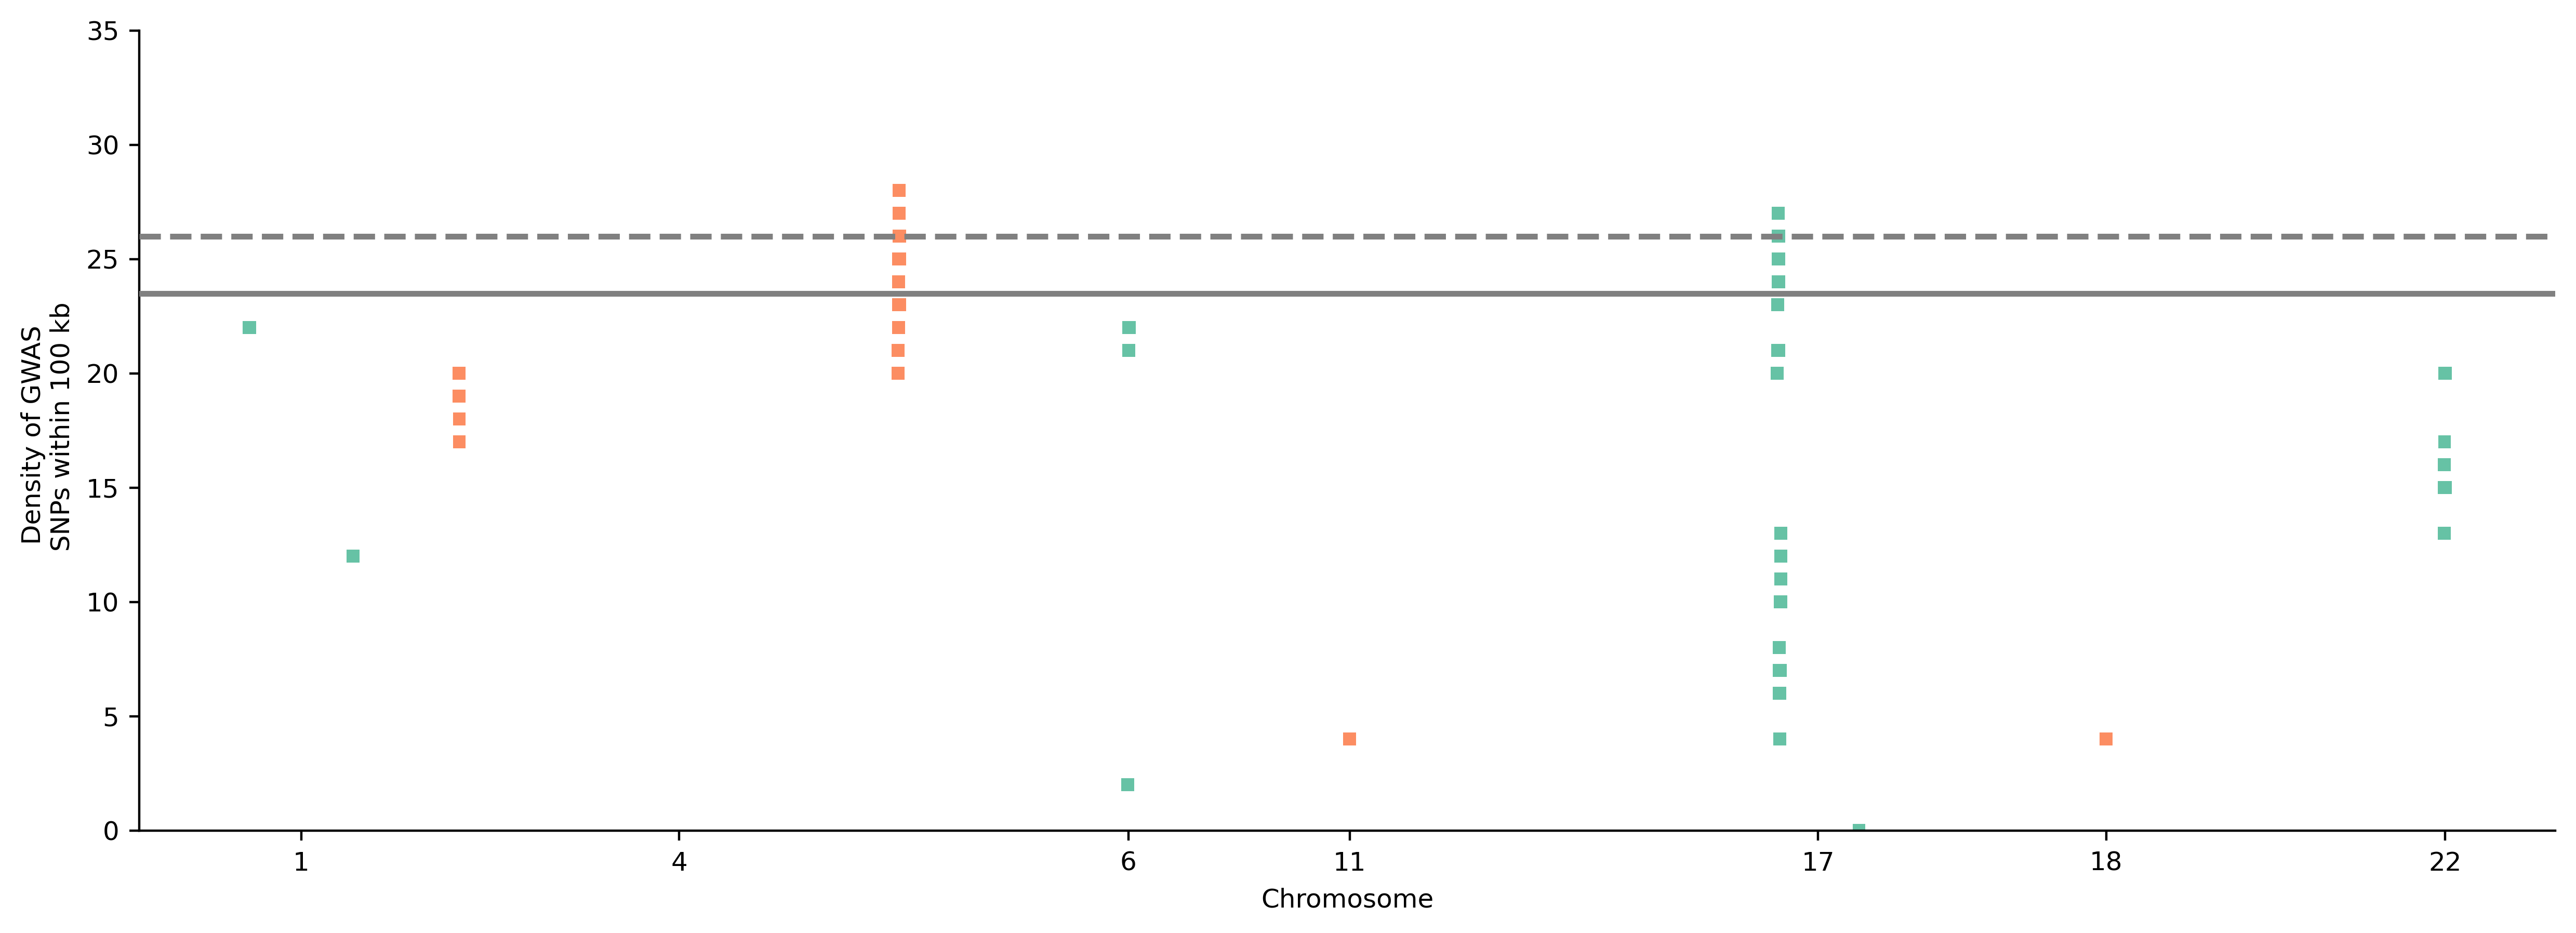

In [12]:
params = {
    'fig_args':{'figsize':(45,14)},
    'dpi':400,
    'colors':['#66c2a5', '#fc8d62'],
    'ylabels':ylabels_converted,
}
gwas_stats.plot_mqq(mode='b', font_family='DejaVu Sans', cut=True, **params)

In [30]:
path_meta = "/home/luis/data/LuxGiantimputed/dependables"
filename = 'pooled_meta_analysis_luxgiant_multi1.tbl'

df_test = pd.read_table(os.path.join(path_meta, filename))
df_test.columns = ['SNP', 'A1',	'A2', 'BETA', 'SE',	'P', 'Direction', 'HetISq',	'HetChiSq',	'HetDf', 'HetPVal']
df_test = df_test.drop(columns=['Direction', 'HetISq',	'HetChiSq',	'HetDf', 'HetPVal'], inplace=False)
df_test

,SNP,A1,A2,BETA,SE,P
0,rs2326918,a,g,0.041410,0.021423,0.05325
1,rs7929618,c,g,0.055195,0.045991,0.23010
2,rs66941928,t,c,-0.005023,0.015343,0.74340
3,rs6039163,t,c,0.107100,0.261214,0.68180
4,rs530960868,t,g,-0.094246,0.078590,0.23040
...,...,...,...,...,...,...
9840149,rs2414744,t,c,-0.039533,0.016437,0.01617
9840150,rs4140461,t,c,0.025396,0.017263,0.14130
9840151,rs7262834,t,g,-0.017171,0.013048,0.18820
9840152,rs117241566,t,c,0.028800,0.034285,0.40090


In [31]:
df_test = df_test[df_test['P']<5e-6].reset_index(drop=True)
df_test = df_test.merge(
    df_gwas[['SNP', 'CHR', 'POS']],
    on='SNP',
    how='inner'
)
df_test

,SNP,A1,A2,BETA,SE,P,CHR,POS
0,rs259029,a,g,-0.116083,0.022845,3.749000e-07,5,80438590
1,rs4336220,t,c,0.149328,0.031372,1.937000e-06,4,15733029
2,rs4653468,a,g,0.076562,0.013740,2.513000e-08,1,226777633
3,rs3734830,a,g,-0.115137,0.019666,4.778000e-09,6,29982544
4,rs35763150,a,g,0.108664,0.020022,5.720000e-08,6,30026394
...,...,...,...,...,...,...,...,...
5167,rs75642179,a,g,0.101757,0.019355,1.462000e-07,15,61782809
5168,rs11754264,t,c,0.131889,0.024096,4.413000e-08,6,29963886
5169,rs1442154,c,g,0.124138,0.019215,1.044000e-10,4,89854610
5170,rs13339578,a,g,0.059921,0.013109,4.857000e-06,16,50705194


In [32]:
df_test, bmean, bmedian = process_density(df_test, 100, 'CHR', 'POS')
df_test

,SNP,A1,A2,BETA,SE,P,CHR,POS,TCHR+POS,DENSITY
1529,rs61763692,t,c,0.065991,0.014349,4.244000e-06,1,18963731,10018963731,0
5130,rs2473304,a,c,0.083401,0.016023,1.939000e-07,1,22026834,10022026834,25
2052,rs2501291,a,g,0.083299,0.016019,1.993000e-07,1,22026921,10022026921,25
466,rs2473300,a,t,-0.082430,0.015994,2.550000e-07,1,22027753,10022027753,25
1415,rs2473298,t,c,0.083559,0.016009,1.795000e-07,1,22027784,10022027784,25
...,...,...,...,...,...,...,...,...,...,...
4137,rs66721116,a,g,0.078599,0.016828,3.002000e-06,22,50367108,220050367108,18
544,rs75156814,a,c,0.078228,0.016896,3.660000e-06,22,50368457,220050368457,18
3095,rs73439371,c,g,0.078499,0.016876,3.293000e-06,22,50368461,220050368461,18
555,rs10775809,a,t,-0.079009,0.016808,2.592000e-06,22,50369588,220050369588,18


In [33]:
metastats = gl.Sumstats(
    df_test, 
    snpid='SNP', 
    chrom='CHR', 
    pos='POS', 
    p='P', 
    build='hg38'
)
metastats.data['CHR'] = metastats.data['CHR'].astype(int)

2024/10/21 10:53:13 GWASLab v3.4.48 https://cloufield.github.io/gwaslab/
2024/10/21 10:53:13 (C) 2022-2024, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
2024/10/21 10:53:13 Start to initialize gl.Sumstats from pandas DataFrame ...
2024/10/21 10:53:13  -Reading columns          : SNP,P,POS,CHR
2024/10/21 10:53:13  -Renaming columns to      : SNPID,P,POS,CHR
2024/10/21 10:53:13  -Current Dataframe shape : 5172  x  4
2024/10/21 10:53:13  -Initiating a status column: STATUS ...
2024/10/21 10:53:13  -Genomic coordinates are based on GRCh38/hg38...
2024/10/21 10:53:13 Start to reorder the columns...v3.4.48
2024/10/21 10:53:13  -Current Dataframe shape : 5172 x 5 ; Memory usage: 20.28 MB
2024/10/21 10:53:13  -Reordering columns to    : SNPID,CHR,POS,P,STATUS
2024/10/21 10:53:13 Finished reordering the columns.
2024/10/21 10:53:14  -Column  : SNPID  CHR    POS   P       STATUS  
2024/10/21 10:53:14  -DType   : object string int64 float64 category
2024/10/21 10:53:14  -Verified: T    

2024/10/21 10:53:14 Start to create MQQ plot...v3.4.48:
2024/10/21 10:53:14  -Genomic coordinates version: 38...
2024/10/21 10:53:14  -Genome-wide significance level to plot is set to 5e-08 ...
2024/10/21 10:53:14  -Raw input contains 5172 variants...
2024/10/21 10:53:14  -MQQ plot layout mode is : b
2024/10/21 10:53:14 Finished loading specified columns from the sumstats.
2024/10/21 10:53:14 Start data conversion and sanity check:
2024/10/21 10:53:14  -Removed 0 variants with nan in CHR or POS column ...
2024/10/21 10:53:14  -Removed 0 variants with CHR <=0...
2024/10/21 10:53:14  -Calculating DENSITY with windowsize of  100  kb
2024/10/21 10:53:14  -Converting data above cut line...
2024/10/21 10:53:14  -Maximum DENSITY value is 348 .
2024/10/21 10:53:14 Finished data conversion and sanity check.
2024/10/21 10:53:14 Start to create MQQ plot with 5172 variants...
2024/10/21 10:53:14  -Creating background plot...
2024/10/21 10:53:14 Finished creating MQQ plot successfully!
2024/10/21 1

(<Figure size 6000x2000 with 1 Axes>, <gwaslab.g_Log.Log at 0x77c0c2901a20>)

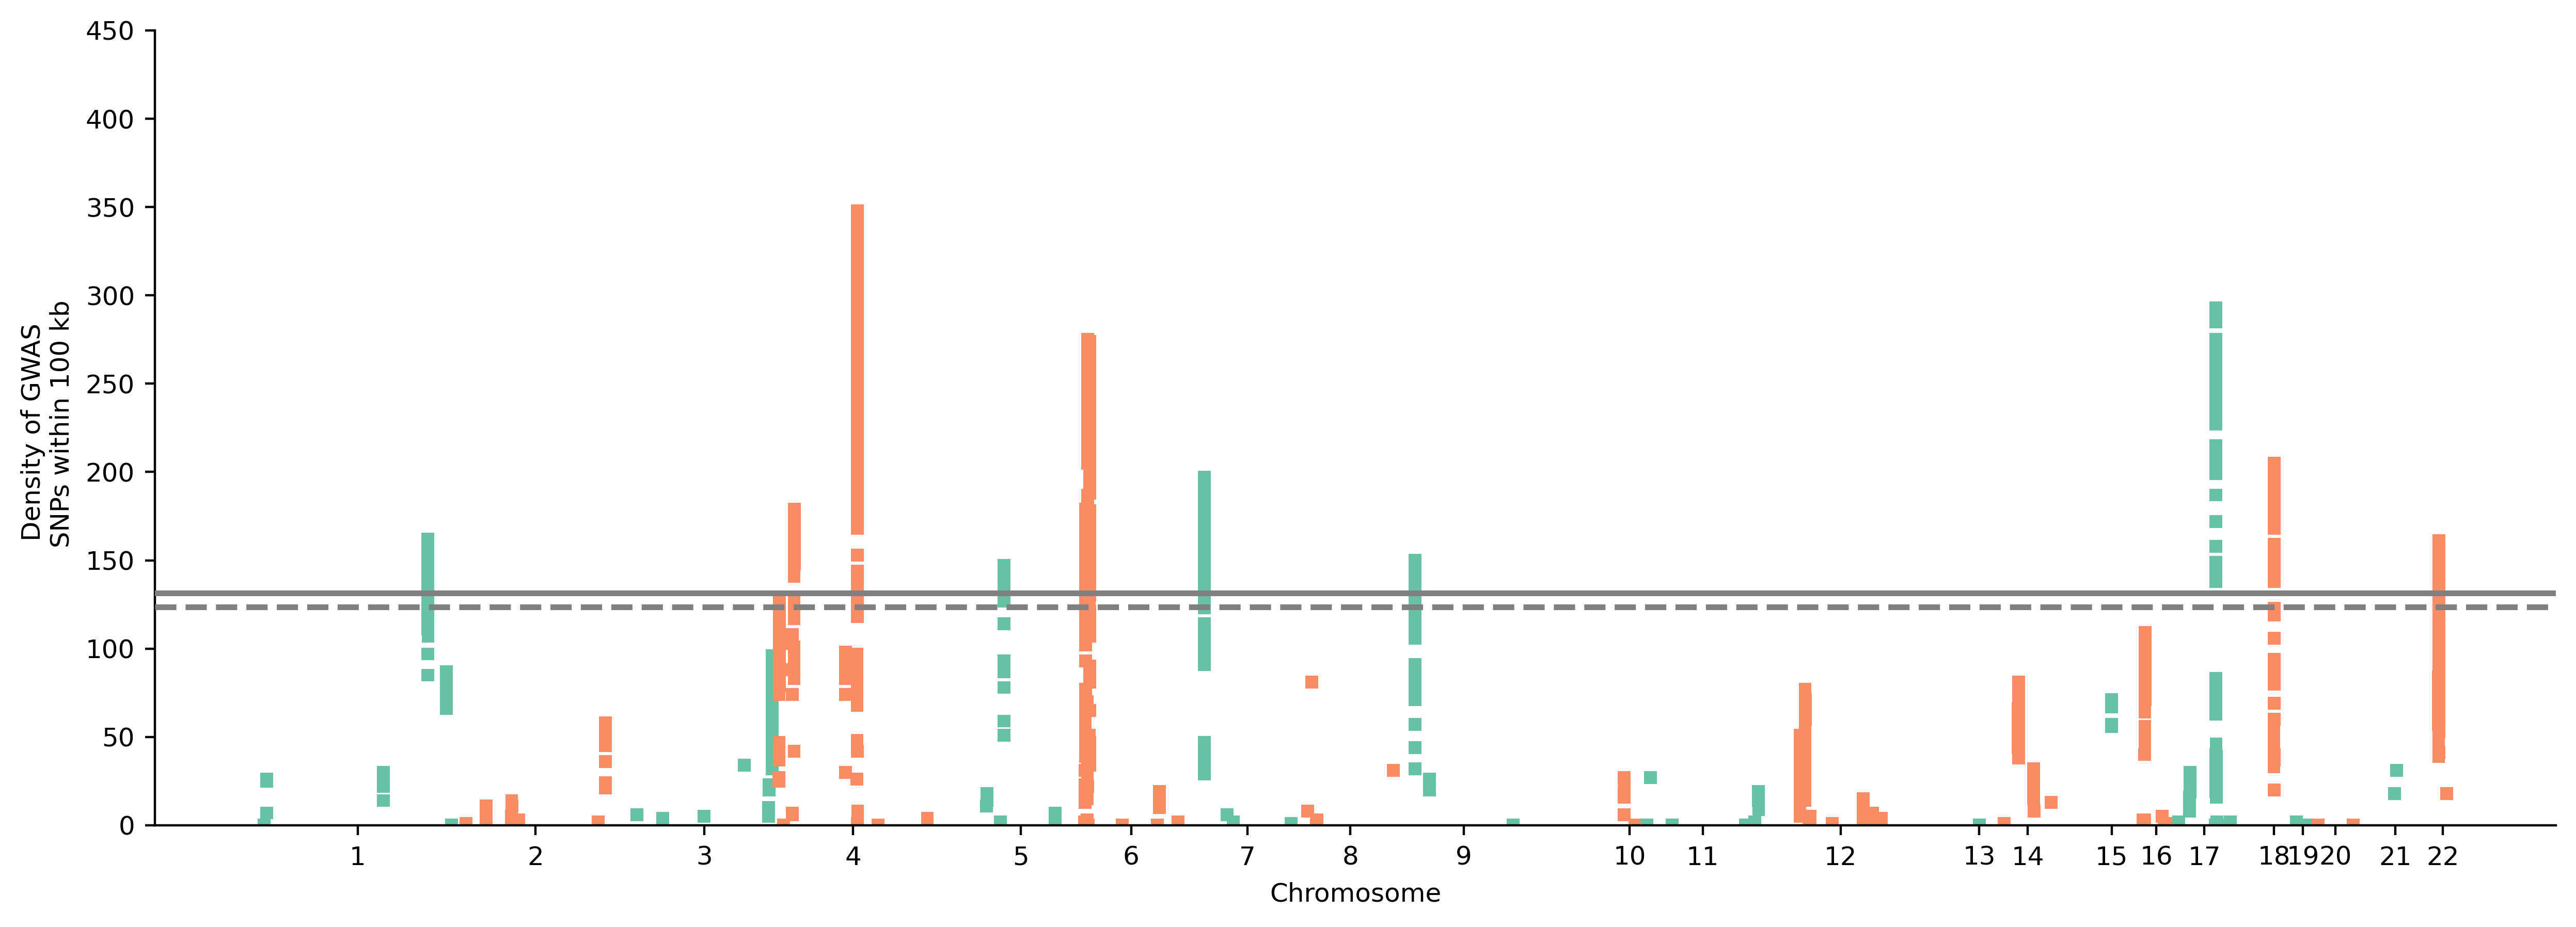

In [34]:

metastats.plot_mqq(mode='b', font_family='DejaVu Sans', cut=False, **params)